In [4]:
from pyke import KeplerTargetPixelFile
%matplotlib inline

In [37]:
import matplotlib.pyplot as plt

In [19]:
from oktopus import UniformPrior, JointPrior

In [25]:
from pyke import PRFPhotometry, SceneModel
from pyke.utils import KeplerQualityFlags

In [26]:
tpf = KeplerTargetPixelFile('https://archive.stsci.edu/missions/k2/target_pixel_files/c12/246100000/99000/ktwo246199087-c12_lpd-targ.fits.gz',
                            quality_mask=KeplerQualityFlags.HARDEST_BITMASK)

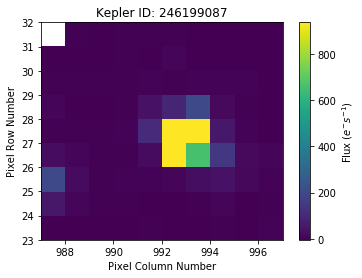

In [27]:
tpf.plot()

In [28]:
prf = tpf.get_prf_model()

In [58]:
prior_column = UniformPrior(lb=990, ub=996)
prior_row = UniformPrior(lb=25, ub=30)
prior_flux = UniformPrior(lb=4e3, ub=2e4)
prior_bkg = UniformPrior(lb=1, ub=2e3)

In [59]:
prior = JointPrior(prior_flux, prior_column, prior_row, prior_bkg)

In [60]:
scene = SceneModel(prfs=[prf])

In [61]:
phot = PRFPhotometry(scene_model=scene, prior=prior)

In [ ]:
results = phot.fit(tpf.flux + tpf.flux_bkg)

  0%|          | 0/3379 [00:00<?, ?it/s]/Users/jvmirca/anaconda3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
 35%|███▍      | 1176/3379 [00:44<01:23, 26.34it/s]/Users/jvmirca/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1850: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/jvmirca/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1851: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/jvmirca/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1852: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)
 94%|█████████▍| 3174/3379 [02:05<00:08, 25.39it/s]

In [ ]:
flux = results[:, 0]
col = results[:, 1]
row = results[:, 2]
bkg = results[:, 3]

In [ ]:
plt.figure(figsize=[14, 4])
plt.plot(tpf.time, flux, 'o', markersize=2)
plt.ylim()

In [ ]:
plt.figure(figsize=[14, 4])
plt.plot(tpf.time, col, 'o', markersize=2)

In [ ]:
plt.figure(figsize=[14, 4])
plt.plot(tpf.time, row, 'o', markersize=2)

(251.23265474502372, 981.67809331283843)

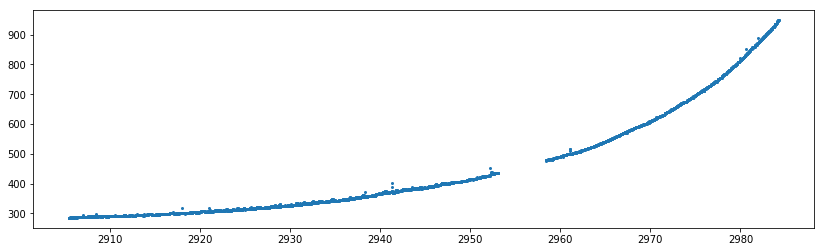

In [55]:
plt.figure(figsize=[14, 4])
plt.plot(tpf.time, bkg, 'o', markersize=2)
